In [1]:
# Title:    MovieLens Matrix Factorization Based Recommender (ALS Edition)
# Author:   Thomas M. Marshall
# Module:   Applied Machine Learning at Scale 813
# Date:     2022/03/22

# Libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from matplotlib import rc
import pandas as pd
import numpy as np
import csv

# Enable TeX
rc('font', **{'size': 14, 'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [ ]:
# Plot stuff
def plotInfo(dataset):
    # Plot the rating distribution
    fig = plt.figure()
    plt.hist(dataset['rating'], bins=5*2, color='blue', alpha=0.5)
    plt.ylabel(r"Count")
    plt.xlabel(r"Rating")
    plt.tight_layout()
    plt.savefig("figures/rating_distribution.png", dpi=300)

    plt.cla()
    movie_ratings =  dataset.groupby(['movieId']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    movie_ratings = movie_ratings['counts'].value_counts().reset_index()
    plt.plot(movie_ratings['index'], movie_ratings['counts'], "x")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r"Movie")
    plt.ylabel(r"Number of ratings")
    plt.savefig("figures/movie_ratings.png", dpi=300)

    plt.cla()
    user_ratings =  dataset.groupby(['userId']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    user_ratings = user_ratings['counts'].value_counts().reset_index()
    plt.plot(user_ratings['index'], user_ratings['counts'], "x")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r"User")
    plt.ylabel(r"Number of ratings")
    plt.savefig("figures/user_ratings.png", dpi=300)
    
    plt.show()

In [2]:
# Load dataset using pandas
ratings = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale/ml-latest-small/ratings.csv')
moviedata = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale/ml-latest-small/movies.csv')

# Reindex movies
movie = ratings['movieId'].value_counts().index
moviemap = {k:i for i, k in enumerate(movie)}
invmoviemap = {v: k for k, v in moviemap.items()}
ratings['movieId'] = ratings['movieId'].map(moviemap)

# Get the number of unique users and movies
num_users = ratings.nunique()['userId']
num_items = ratings.nunique()['movieId']

In [3]:
# User and movie ratings indexed by record
user_ratings = ratings.to_numpy()[:, [1, 2]]
movie_ratings = ratings.sort_values("movieId").to_numpy()[:, [0, 2]]

# Now make arrays storing the stop and start indices of a particular user and movie's records
user_index = np.zeros((num_users, 2))
movie_index = np.zeros((num_items, 2))

# Index user stops and starts
prev_user = 0
for m in range(num_users):
    user_data = len(ratings[ratings['userId'] == (m + 1)])
    stop_index = prev_user + user_data

    user_index[m][0] = prev_user
    user_index[m][1] = stop_index

    prev_user = stop_index

# Index movie stops and starts
prev_movie = 0
for n in range(num_items):
    movie_data = len(ratings[ratings['movieId'] == n])
    stop_index = prev_movie + movie_data

    movie_index[n][0] = prev_movie
    movie_index[n][1] = stop_index

    prev_movie = stop_index

# Save indexed information
with open('trained_models/als_100k_index.npy', 'wb') as f:
    np.save(f, user_ratings)
    np.save(f, movie_ratings)
    np.save(f, user_index)
    np.save(f, movie_index)

In [3]:
# Load indexed information
with open('trained_models/als_100k_index.npy', 'rb') as f:
    user_ratings = np.load(f)
    movie_ratings = np.load(f)
    user_index = np.load(f)
    movie_index = np.load(f)

In [4]:
# Backsolving using Cholesky decomp. for numerical stability
def backsolve(A, c):
    L = np.linalg.cholesky(A)
    Z = np.linalg.solve(L, c)
    Y = np.linalg.solve(L.T, Z)
    return Y

# Function that takes a user and a movie, produces a prediction
def predict(m, n, zm, zn, versionID):
    if(versionID == 0): # Group A
        return ((zm[0:-1, m][np.newaxis] @ zn[0:-1, n][np.newaxis].T).ravel()[0] + (zn[-1, n] + zm[-1, m]))
    else: # Group B
        return ((zm[0:-1, m][np.newaxis] @ zn[0:-1, n][np.newaxis].T).ravel()[0]*0.95 + 0.05*(zn[-1, n] + zm[-1, m]))

# Implementation of Alternating Least Squares (ALS)
def ALS(zm, zn, l, lamda, tau, N=10, epsilon=0.0001):
    print("Starting ALS for", N, "iterations")
    errors = []

    # Repeat ALS N times
    for _ in range(N):

        # Phase 1: Update every user who has seen movies
        for m in range(len(user_index)):
            ysum = np.zeros((l + 1, l + 1))
            xsum = np.zeros((l + 1, 1))
            for record in range(int(user_index[m][0]), int(user_index[m][1])):
                movie = int(user_ratings[record][0])
                r = user_ratings[record][1]

                yn = dc(zn[:, movie])
                yn[-1] = 1.0
                yn = yn[np.newaxis].T

                ysum += yn @ yn.T

                xmn = r - zn[-1, movie]
                xsum += xmn * yn

            I = np.identity(l + 1)
            I[-1, -1] = epsilon

            zm_movie = backsolve((ysum * lamda + I*tau), (xsum * lamda))

            zm[:, m] = np.reshape(zm_movie, (l + 1))

        # Phase 2: Update every movie that has been seen by users
        for n in range(len(movie_index)):
            ysum = np.zeros((l + 1, l + 1))
            xsum = np.zeros((l + 1, 1))
            for record in range(int(movie_index[n][0]), int(movie_index[n][1])):
                user = int(movie_ratings[record][0]) - 1
                r = movie_ratings[record][1]

                ym = dc(zm[:, user])
                ym[-1] = 1.0
                ym = ym[np.newaxis].T

                ysum += ym @ ym.T
                                
                xmn = r - zm[-1, user]
                xsum += + xmn * ym

            I = np.identity(l + 1)
            I[-1, -1] = epsilon

            zn_user = backsolve((ysum * lamda + I*tau), (xsum * lamda))

            zn[:, n] = np.reshape(zn_user, (l + 1))

        # Compare predictions to true values using RMSE
        mse = 0.0
        R = 0
        # For every user
        for m in range(len(user_index)):
                # For every movie that user has seen
                for record in range(int(user_index[m][0]), int(user_index[m][1])):
                    # Make a prediction
                    movie = int(user_ratings[record][0])
                    r = user_ratings[record][1]

                    r_hat = (zm[0:-1, m][np.newaxis] @ zn[0:-1, movie][np.newaxis].T).ravel()[0]
                    r_hat += (zm[-1, m] + zn[-1, movie])
                    
                    # Calculate MSE
                    mse += (r_hat - r)**2
                    R += 1

        # Calculate RMSE
        rmse = np.sqrt((1.0/R) * mse)
        errors.append(rmse)

        print('Iteration:', _,"\tRMSE:", round(rmse, 4))
        
    # Save as numpy arrays for backup after every iteration
    with open('trained_models/als_100k_params.npy', 'wb') as f:
        np.save(f, zm)
        np.save(f, zn)

    return zm, zn, errors

In [5]:
# Set up the recommender for training
latent_dims = 20

# Do alternating least squares to fit to data
tau =  3.0 * np.sqrt(latent_dims) / 2.5
lamda = 1.0

# Initialize user and item vectors, uniformly distributed values
zm = np.random.normal(0, np.sqrt(1.0/tau), (latent_dims + 1, num_users))
zn = np.random.normal(0, np.sqrt(1.0/tau), (latent_dims + 1, num_items))

# Initialize biases to zero
zm[-1, :] = 0.0
zn[-1, :] = 0.0

Starting ALS for 5 iterations
Iteration: 0 	RMSE: 0.4703
Iteration: 1 	RMSE: 0.4698
Iteration: 2 	RMSE: 0.4694
Iteration: 3 	RMSE: 0.469
Iteration: 4 	RMSE: 0.4686


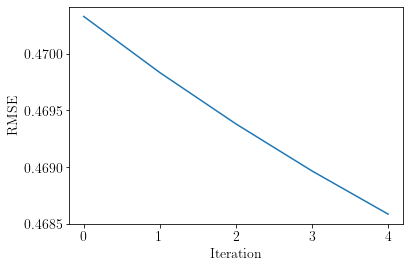

In [37]:
# Train the model
zm, zn, rmse = ALS(zm, zn, latent_dims, lamda, tau, 5)

# Plot the error over epochs
plt.figure()
plt.plot(range(len(rmse)), rmse)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.savefig('figures/rmse.jpg', dpi=300)
plt.show()

In [6]:
# Load trained parameters
with open('trained_models/als_100k_params.npy', 'rb') as f:
    zm = np.load(f)
    zn = np.load(f)

In [7]:
# Choose a user number
user = 44

# Choose the number of movies to display
topN = 10

In [9]:
# Find the users top N movies
ratings = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale/ml-latest-small/ratings.csv')
moviedata = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale//ml-latest-small/movies.csv')
users_movies = ratings[ratings['userId'] == user].nlargest(topN, 'rating')

# Add the natural language movie titles
users_movies['movieId'] = users_movies['movieId'].replace(moviedata.set_index('movieId')['title'])

# Display in the notebook
users_movies

,userId,movieId,rating,timestamp
6440,44,Rumble in the Bronx (Hont faan kui) (1995),5.0,869251955
6443,44,Star Wars: Episode IV - A New Hope (1977),5.0,869251910
6451,44,"Rock, The (1996)",5.0,869251910
6453,44,Barb Wire (1996),5.0,869252012
6467,44,Star Wars: Episode VI - Return of the Jedi (1983),5.0,869252333
6471,44,First Strike (Police Story 4: First Strike) (G...,5.0,869252417
6472,44,Private Parts (1997),5.0,869252362
6476,44,Chasing Amy (1997),5.0,895853739
6433,44,Four Rooms (1995),4.0,869252115
6434,44,Dead Man Walking (1995),4.0,869251910


In [10]:
# Make predictions for all the movies the user has seen and rank them
unseen = []
for n in range(num_items):
    start, stop = int(user_index[user-1, 0]), int(user_index[user-1, 1])
    if n in user_ratings[start:stop, 0]:
        # Movie the user has not seen
        r = predict(user-1, n, zm, zn, 1)
        unseen.append({'movieId':n, 'predicted rating':r})

unseenmovies = pd.DataFrame(unseen).nlargest(topN, 'predicted rating')
unseenmovies['movieId'] = unseenmovies['movieId'].map(invmoviemap)

# Add the natural language movie titles
unseenmovies['movieId'] = unseenmovies['movieId'].replace(moviedata.set_index('movieId')['title'])

# Display in the notebook
unseenmovies

,movieId,predicted rating
33,Barb Wire (1996),0.848558
35,First Strike (Police Story 4: First Strike) (G...,0.768223
8,Austin Powers: International Man of Mystery (1...,0.749284
19,Chasing Amy (1997),0.699469
9,Happy Gilmore (1996),0.591810
0,Star Wars: Episode IV - A New Hope (1977),0.582914
29,Beavis and Butt-Head Do America (1996),0.569671
22,Rumble in the Bronx (Hont faan kui) (1995),0.556230
6,"Rock, The (1996)",0.495289
26,Executive Decision (1996),0.454183


In [12]:
# Make predictions for all the movies a user has not seen and rank them
unseen = []
for n in range(num_items):
    start, stop = int(user_index[user-1, 0]), int(user_index[user-1, 1])
    if n not in user_ratings[start:stop, 0]:
        # Movie the user has not seen
        r = predict(user-1, n, zm, zn, 0)
        unseen.append({'movieId':n, 'predicted rating':r})

unseenmovies = pd.DataFrame(unseen).nlargest(topN, 'predicted rating')
unseenmovies['movieId'] = unseenmovies['movieId'].map(invmoviemap)

# Add the natural language movie titles
unseenmovies['movieId'] = unseenmovies['movieId'].replace(moviedata.set_index('movieId')['title'])

# Display in the notebook
unseenmovies

,movieId,predicted rating
7378,"Match Factory Girl, The (Tulitikkutehtaan tytt...",6.411793
8991,Galaxy of Terror (Quest) (1981),6.404657
9099,Alien Contamination (1980),6.404657
9456,Villain (1971),6.185195
7751,Paterson,5.912556
8986,Looker (1981),5.905180
9161,Master of the Flying Guillotine (Du bi quan wa...,5.905180
9461,Bossa Nova (2000),5.826915
5453,"Jetée, La (1962)",5.703233
4934,Come and See (Idi i smotri) (1985),5.685184


In [8]:
# High-level API
def recommend(userID, versionID, N=20):
    # Recommend N movies for userID in group versionID

    # Step 1: Make predictions for all the movies a user has not seen and rank them
    unseen = []
    for n in range(num_items):
        start, stop = int(user_index[userID - 1, 0]), int(user_index[userID - 1, 1])
        if n not in user_ratings[start:stop, 0]:
            r = predict(userID - 1, n, zm, zn, versionID)
            unseen.append({'movieId':n, 'predicted rating':r})

    # Create panda dataframe and rank the movies
    recommendations = pd.DataFrame(unseen).nlargest(N, 'predicted rating')
    recommendations['movieId'] = recommendations['movieId'].map(invmoviemap)

    # Add the natural language movie titles
    recommendations['movieName'] = recommendations['movieId']
    recommendations['Genres'] = recommendations['movieId']
    recommendations['movieName'] = recommendations['movieName'].replace(moviedata.set_index('movieId')['title'])
    recommendations['Genres'] = recommendations['Genres'].replace(moviedata.set_index('movieId')['genres'])
    del recommendations['predicted rating']

    # Return python list
    return recommendations.values.tolist()

In [9]:
recommend(1, 1, 1)

[[4718, 'American Pie 2 (2001)', 'Comedy']]

In [10]:
# Conduct A/B test 
# A -> p = uv + b
# B -> p = uv * 0.95 + b * 0.05

# Split users into two groups A and B
A = []
B = []
users = (np.arange(1, num_users + 1))
print(len(users), "users have been split into groups of")
np.random.shuffle(users)
for user in users:
    if(np.random.uniform() < 0.5): A.append(user)
    else: B.append(user)

print("\tA:", len(A))
print("\tB:", len(B))

# Open the logging file
f = open('logs/ALS_log.csv', 'w')
writer = csv.writer(f)

# Run the test for the control group A
for user in A: 
    # Recommend movies
    movies = recommend(user, 0)

    # Simulate feedback
    feedback = 0 if np.random.uniform() < 0.5 else 1

    # Log data
    writer.writerow([user, 'A', feedback, movies])

# Run the test for the treatment group B
for user in B: 
    # Recommend movies
    movies = recommend(user, 1)
    
    # Simulate feedback: the users in B enjoy more
    feedback = 0 if np.random.uniform() < 0.25 else 1

    # Log data
    writer.writerow([user, 'B', feedback, movies])

# Close the logging file
f.close()

610 users have been split into groups of
	A: 294
	B: 316


In [11]:
# Calculate the overall evaluation metric for both groups
file = open('logs/ALS_log.csv')
csvreader = csv.reader(file)
    
A, B = [], []
for row in csvreader:
    if(row[1] == 'A'):
        A.append(int(row[2]))
    else:
        B.append(int(row[2]))

print("A:", round(np.mean(A), 2), "\nB:", round(np.mean(B), 2))

A: 0.45 
B: 0.72


In [ ]:
# Plot the item biases
fig = plt.figure()
plt.scatter(np.arange(0, len(zn[-1, :])), zn[-1, :], s=1, color='blue', alpha=0.5)
plt.ylabel(r"Bias")
plt.xlabel(r"Item") 
plt.tight_layout()
plt.savefig("figures/item_bias_ALS.jpg", dpi=300)


# Plot the user biases
fig = plt.figure()
plt.scatter(np.arange(0, len(zm[-1, :])), zm[-1, :], s=1, color='blue', alpha=0.5)
plt.ylabel(r"Bias")
plt.xlabel(r"User") 
plt.tight_layout()
plt.savefig("figures/user_bias_ALS.jpg", dpi=300)

In [44]:
# Find a t-sne embedding of the item vectors (excluding the bias of course)
tsne_movies = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=100).fit_transform(zn[:-1, :].T)

In [59]:
# function to find the genres of a specific movie ID
def getGenre(movieId):
    moviedata = pd.read_csv('~/Documents/University/msc-mlai/ML at Scale//ml-latest-small/movies.csv')

    moviess = moviedata
    moviess['movieId'] = moviess['movieId'].map(moviemap)
    x = moviess[moviess['movieId'] == movieId].to_numpy()[0][2].split('|')
    return x

['Comedy', 'Drama', 'Romance', 'War']

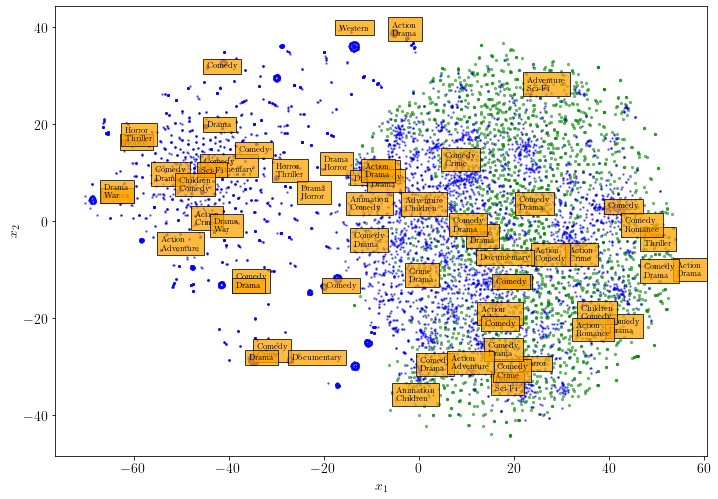

In [178]:
# Plot the 2D dims tsne
fig = plt.figure()
for x in range(num_items):
    if(x < 2300): # 80% of the ratings change the number still. pareto principle
        c = 'green' 
        dot = 5
    else:
        c = 'blue' # rest
        dot = 2

    plt.scatter(tsne_movies.T[0, x], tsne_movies.T[1, x], s=dot, color=c, alpha=0.5)

have = []
for x in range(60):

    y = np.random.choice(np.arange(num_items))
    genres = getGenre(y)
    if(len(genres) > 2): genres = genres[:2]
    g = '\n'.join(genres)
    plt.text(tsne_movies.T[0, y], tsne_movies.T[1, y], g, fontsize=8, usetex=True, bbox=dict(facecolor='orange', alpha=0.75))


plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$") 
fig.set_size_inches(11.69, 8.27)
plt.savefig("figures/2D_ALS_movies_tsne.jpg", dpi=300)
plt.show()
